## Import Packages

In [1]:
import os
import pickle
import rdkit.Chem as Chem
import rdkit.Chem.AllChem as AllChem
from rdkit.Chem import PandasTools

import random
import pickle
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
# from torch_geometric.nn.conv import RGATConv, RGCNConv, GCNConv, GATConv
from torch_geometric.nn.conv import GCNConv, GATConv
from torch_geometric.nn.pool import global_mean_pool

## Curate Dataset

In [2]:
infile = "../data/combined_training_datasets_unique.sdf"
name = os.path.splitext(os.path.basename(infile))[0]

all_df = PandasTools.LoadSDF(infile)
all_df.head()

[15:11:26] Warning: ambiguous stereochemistry - overlapping neighbors  - at atom 13 ignored


,pKa,marvin_pKa,marvin_atom,marvin_pKa_type,original_dataset,ID,ROMol
0,6.21,6.09,10,basic,['chembl25'],1702768,<rdkit.Chem.rdchem.Mol object at 0x7fb7bcea1150>
1,7.46,8.2,9,basic,['chembl25'],273537,<rdkit.Chem.rdchem.Mol object at 0x7fb6b16dd540>
2,4.2,3.94,9,basic,['datawarrior'],7175,<rdkit.Chem.rdchem.Mol object at 0x7fb6b16dd5b0>
3,3.73,5.91,8,acidic,['datawarrior'],998,<rdkit.Chem.rdchem.Mol object at 0x7fb6b16dd620>
4,11.0,8.94,13,basic,['chembl25'],560562,<rdkit.Chem.rdchem.Mol object at 0x7fb6b16dd690>


In [3]:
# TYPES = [
#     Chem.rdchem.BondType.SINGLE,
#     Chem.rdchem.BondType.DOUBLE,
#     Chem.rdchem.BondType.TRIPLE,
#     Chem.rdchem.BondType.AROMATIC,
#     Chem.rdchem.BondType.OTHER,
#     ]
# TYPE2DCT = {t: (np.eye(len(TYPES))[idx]).tolist() for idx, t in enumerate(TYPES)}

ATOMS = ['C', 'O', 'S', 'N', 'P', 'H', 'F', 'Cl', 'Br', 'I', 'UNK']
ATOM2DCT = {ele: (np.eye(len(ATOMS))[idx]).tolist() for idx, ele in enumerate(ATOMS)}
HYBRIDS = [Chem.rdchem.HybridizationType.SP,
    Chem.rdchem.HybridizationType.SP2,
    Chem.rdchem.HybridizationType.SP3,
    Chem.rdchem.HybridizationType.SP3D,
    Chem.rdchem.HybridizationType.SP3D2,
    'UNK']
HYBRID2DCT = {ele: (np.eye(len(HYBRIDS))[idx]).tolist() for idx, ele in enumerate(HYBRIDS)}

def featurize(mol):
    x = []
    Chem.Kekulize(mol)
    mol = Chem.RemoveHs(mol)
    AllChem.ComputeGasteigerCharges(mol)
    Chem.AssignStereochemistry(mol)
    ring = mol.GetRingInfo()
    for idx in range(mol.GetNumAtoms()):
        emd = []
        at = mol.GetAtomWithIdx(idx)
        ele = at.GetSymbol()
        ele = ele if ele in ATOMS else 'UNK'
        emd += ATOM2DCT[ele]
        emd += [at.GetDegree()]
        hyb = at.GetHybridization()
        hyb = hyb if hyb in HYBRIDS else "UNK"
        emd += HYBRID2DCT[hyb]
        emd += [at.GetImplicitValence()]
        emd += [at.GetIsAromatic()]
        emd += [ring.IsAtomInRingOfSize(idx, 3),
              ring.IsAtomInRingOfSize(idx, 4),
              ring.IsAtomInRingOfSize(idx, 5),
              ring.IsAtomInRingOfSize(idx, 6),
              ring.IsAtomInRingOfSize(idx, 7),
              ring.IsAtomInRingOfSize(idx, 8)]
        emd += [at.GetFormalCharge()]
        x.append(emd)
    x = torch.from_numpy(np.array(x, dtype=float))
    
    bonds = []
    # types = []
    for bond in mol.GetBonds():
        idx1 = bond.GetBeginAtomIdx()
        idx2 = bond.GetEndAtomIdx()
        t = bond.GetBondType()
        # t = t if t in TYPES else Chem.rdchem.BondType.OTHER
        bonds.append([idx1, idx2])
        # types.append(TYPE2DCT[t])
        bonds.append([idx2, idx1])
        # types.append(TYPE2DCT[t])
    edge_index = torch.from_numpy(np.array(bonds))
    # edge_type = torch.from_numpy(np.array(types))
    # data = Data(x=x, edge_index=edge_index.t().contiguous(), edge_type=edge_type)
    data = Data(x=x, edge_index=edge_index.t().contiguous())
    return data

outfile = f"../data/{name}_graph_training.pkl"
DATA = []
for idx, row in all_df.iterrows():
    mol = row["ROMol"]
    data = featurize(mol)
    y = torch.Tensor([float(row["pKa"])])
    DATA.append((data, y))

with open(outfile, "wb") as file:
    pickle.dump(DATA, file)

## Graph Neural Network

References:
- [Explainable Graph Neural Networks with Data Augmentation for Predicting pKa of C–H Acids](https://pubs.acs.org/doi/10.1021/acs.jcim.3c00958)
- [MolGpka: A Web Server for Small Molecule pKa Prediction Using a Graph-Convolutional Neural Network](https://pubs.acs.org/doi/10.1021/acs.jcim.1c00075)

In [4]:
# for reproduce purposes
SEED = 0
random.seed(SEED)
np.random.seed(SEED)

datadir = "."
infile = "../data/combined_training_datasets_unique_graph_training.pkl"
ratio = 0.1
batch_size = 256
device = "cuda" if torch.cuda.is_available() else "cpu"

## Load data

In [5]:
with open(infile, "rb") as file:
    DATA = pickle.load(file)
nsamples = len(DATA)
print(f"Number of samples: {nsamples}")

val_size = int(nsamples*ratio)
train_data = DATA[:val_size]
test_data = DATA[val_size:]

d = train_data[0][0]
ndim = d.x.shape[1]
num_relations = len(TYPES)
print(f"Dimension of node feature: {ndim}")
print(f"Number of edge types: {num_relations}")

/home/mxue33/anaconda3/envs/sphinx/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(io.BytesIO(b))


Number of samples: 5994


NameError: name 'TYPES' is not defined

### Graph Batching

In [ ]:
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

## Model

In [ ]:
class Model(nn.Module):
    def __init__(self, ndim, hidden_dims, num_relations, type):
        super(Model, self).__init__()
        total_dims = [ndim] + hidden_dims
        net = []
        self.bn = nn.BatchNorm1d(total_dims[0])
        for i in range(len(total_dims)-1):
            net.extend([
                GCNConv(total_dims[i], total_dims[i+1], add_self_loops=True),
                nn.ELU(),
            ])
        self.net = nn.Sequential(*net)
        self.fc = nn.Linear(total_dims[-1], 1)
        self.type = type
        

    def forward(self, data):
        batch = data.batch
        out = data.x
        edge_type = data.edge_type
        if self.type == "float":
            out = out.float()
            edge_type = edge_type.float()
        elif self.type == "double":
            out = out.double()
            edge_type = edge_type.double()
        else:
            raise TypeError(f"{self.type} not supported")
        out = self.bn(out)
        edge_index = data.edge_index.long()
        
        for idx in range(len(self.net)//2):
            out = self.net[2*idx](out, edge_index)
            out = self.net[2*idx+1](out)
        out = global_mean_pool(out, batch)
        out = self.fc(out)
        return out

In [ ]:
def train_epoch(dataloader, model, loss_func, optimizer, device):
    model.train()
    train_loss = []
    for (x, y) in dataloader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            y_pred = model(x)
            loss = loss_func(y_pred, y)
            loss.backward()
            optimizer.step()
            train_loss.append(loss.detach().cpu().numpy())
    return np.mean(train_loss)

def val_epoch(dataloader, loss_func, model, device):
    model.eval()
    val_loss = []
    with torch.no_grad():
        for (x, y) in dataloader:
            x, y = x.to(device), y.to(device)
            y_pred = model(x)
            loss = loss_func(y_pred, y)
            val_loss.append(loss.detach().cpu().numpy())
    return np.mean(val_loss)

## Training

In [ ]:
epochs = 20
lr = 1e-2
dtype = "float"
model = Model(ndim, hidden_dims=[100, 50, 20], num_relations=num_relations, type=dtype)
model.to(device)
model = model.float() if dtype == "float" else model.double()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
loss_func = nn.functional.mse_loss

train_epoch_losses, test_epoch_losses = [], []
for n in range(epochs):
    train_epoch_loss = train_epoch(train_loader, model, loss_func, optimizer, device)
    val_epoch_loss = val_epoch(test_loader, loss_func, model, device)
    train_epoch_losses.append(train_epoch_loss)
    test_epoch_losses.append(val_epoch_loss)

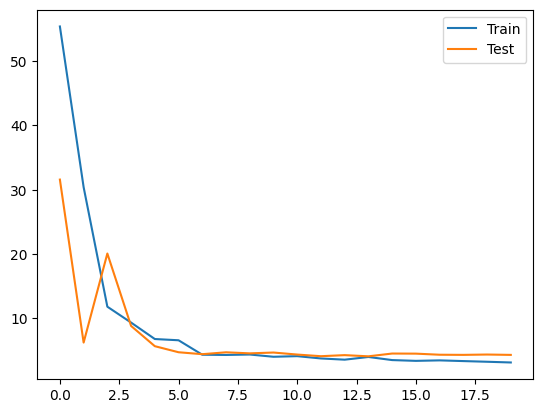

In [ ]:
plt.plot(train_epoch_losses, label="Train")
plt.plot(test_epoch_losses, label="Test")
plt.legend()

## Analysis

tensor(4.2569)


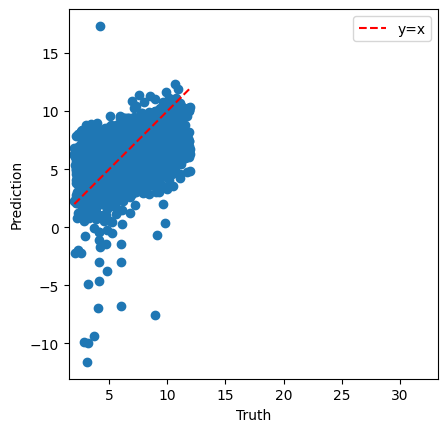

In [ ]:
model.eval()

truth = []
pred = []
with torch.no_grad():
    for (x, y) in test_loader:
        x, y = x.to(device), y.to(device)
        y_pred = model(x)
        truth.extend(y.cpu().numpy().tolist())
        pred.extend(y_pred.cpu().numpy().tolist())
loss = loss_func(torch.Tensor(pred), torch.Tensor(truth))
print(loss)

xreg = np.linspace(2, 12, num=100)
yreg = xreg
plt.plot(xreg, yreg, 'r--', label="y=x")
plt.scatter(truth, pred)
plt.xlabel("Truth")
plt.ylabel("Prediction")
plt.axis("square")
plt.legend()